<a href="https://colab.research.google.com/github/predicthq/phq-data-science-docs/blob/master/demand-surge/demand-surge-notebook.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demand surges
Demand surges reflect an unusual increase in daily event impact for a location and date range. In this notebook, we use the [Features API](https://docs.predicthq.com/datascience/features-api/) to scan and identify potential surge or outlier dates by looking at the total daily attendance of [Attended Events](https://docs.predicthq.com/categoryinfo/attended-events/). Surge dates are defined as dates where the total daily attendance value is more than 3 standard deviations away from the mean (for a location and date range). If one or more surge dates are identified, the total daily attendance and examples of top events are returned per date. Running the notebook is simple and only requires a location, date range and Access Token.

# Sections
* [Setup](#setup)
* [Getting started](#getting-started)
* [Map of location](#map-of-location)
* [Features API](#features-api)
* [Outlier days](#outlier-days)
* [Events API](#events-api)

# Setup <a class="anchor" id="setup"></a>
If using Google Colab uncomment the following code block.

In [148]:
# %%capture
# !git clone https://github.com/predicthq/phq-data-science-docs.git
# %cd phq-data-science-docs/demand-surge
# !pip install predicthq==1.9.0 timezonefinder==5.2.0 pyjanitor==0.21.2 tonyg-rfc3339==0.1 plotly-express==0.4.1 plotly==5.3.1 folium==0.12.1

In [149]:
%pwd

'C:\\Users\\PredictHQ\\anaconda3\\Scripts\\other\\demand surge'


If running locally, configure the required dependencies in your Python environment by using the [requirements.txt](https://github.com/predicthq/phq-data-science-docs/blob/master/demand-surge/requirements.txt) file which is shared alongside the notebook.

These requirements can be installed by runing the command `pip install -r requirements.txt`


In [150]:
import requests
import json

from predicthq import Client
from timezonefinder import TimezoneFinder

import pandas as pd
import numpy as np
from janitor import clean_names
import datetime
import rfc3339
import pytz
from itertools import chain
from IPython.display import display
import math
import plotly_express as px
import folium

In [151]:
pd.set_option("display.max_columns", None)

# Getting started <a class="anchor" id="getting-started"></a>

## Access Token

An Access Token is required to query the API.

The following link will guide you through creating an account and an access token. 
Please make sure your token has features-api scope. 
 - https://docs.predicthq.com/guides/quickstart/

Please update `ACCESS_TOKEN` to query the Features API, Events API and Places API.

In [152]:
ACCESS_TOKEN = ACCESS_TOKEN # replace with own access token 
phq = Client(access_token=ACCESS_TOKEN)

## Finding `place_id` (optional)

The location can be specified using either `latitude`, `longitude` and `radius` or `place_id`. The following call to the Places API can help you find the correct `place_id` given a location name. More information (including links to `country_alpha2` codes) can be found in the [Places Technical Documentation](https://docs.predicthq.com/resources/places/). 

In [153]:
for place in [p for p in phq.places.search(q="London") if p.country_alpha2 == "GB"]:
    print(
        place.id,
        place.country,
        place.region,
        place.name,
        place.type,
        place.location,
    )

2643743 United Kingdom England London locality [-0.12574, 51.50853]
2648110 United Kingdom England Greater London county [-0.16667, 51.5]
2643741 United Kingdom England City of London locality [-0.09184, 51.51279]


## Parameters

Please complete the following steps before running the notebook:
1. Update the search date range parameters (the recommended search date range is 90 days, which is also the maximum currently supported)
2. Update the location parameters, setting `LOCATION_SETTING` to either `place_id` or `lat/lon`
    1. If `LOCATION_SETTING` is `place_id`, update `place_id` 
    2. If `LOCATION_SETTING` is `lat/lon`, update `latitude`, `longitude`, `radius` and `radius_unit` 

In [154]:
# search date range parameters
start = "2021-05-12"  # replace start
n_days = 89  # replace number of days (less than 90 days)

In [155]:
# location parameters
LOCATION_SETTING = "place_id"  # set to "lat/lon" or "place_id"

# if LOCATION_SETTING is lat/lon, update latitude, longitude, radius and radius_unit (otherwise set as None)
# radius should be an integer; supported radius units: "km", "mi", "m"
# example: 51.50853, -0.12574, 20, "km"
latitude = None
longitude = None
radius = None
radius_unit = None

# if LOCATION_SETTING is place_id, update place_id (otherwise set as None)
place_id = 2643743

if LOCATION_SETTING == "place_id":
    location = phq.places.search(id=place_id).results[0].location
    latitude = location[1]
    longitude = location[0]

# Map of location <a class="anchor" id="map-of-location"></a>

In [156]:
f = folium.Figure(width=1300, height=450)

m = folium.Map(location=[latitude, longitude], zoom_start=9)

folium.Marker(
    [latitude, longitude],
).add_to(m)

if LOCATION_SETTING == "lat/lon":

    if radius_unit == "km":
        multiplier = 1000
    elif radius_unit == "m":
        multiplier = 1
    elif radius_unit == "mi":
        multiplier = 1609

    folium.Circle(
        radius=radius * multiplier,
        location=[latitude, longitude],
        popup="The Waterfront",
        color="black",
        fill=False,
    ).add_to(m)

f.add_child(m)

f

# python SDK <a class="anchor" id="features-api"></a>

In [157]:
def get_end_date(start, n_days=89):
    """Define end search date"""

    start_dt = datetime.date.fromisoformat(start)

    # end date taking into account the 90 days restriction
    n_days_min = min(n_days, 89)
    end_dt = start_dt + datetime.timedelta(days=n_days_min)

    end = end_dt.strftime("%Y-%m-%d")

    return end

## Python SDK stats

In [158]:
#double check the date range of interest
end = get_end_date(start=start, n_days=n_days)
print("Dates of interests are from {} to {}".format(start, end))

Dates of interests are from 2021-05-12 to 2021-08-09


In [159]:
# Note: if you're getting 400 errors, it's probably because your token doesn't have features-api scope and you can generate a new one by following the steps in 4.1
feature_list = []
for feature in phq.features.obtain_features(
        active__gte=start,
        active__lte=end,
        location__geo= {"lat": latitude, "lon": longitude, "radius": f"{radius}{radius_unit}"} if LOCATION_SETTING == "lat/lon" else None, 
        location__place_id = place_id if LOCATION_SETTING == "place_id" else None, 
        phq_rank_public_holidays=True,
        phq_attendance_sports__stats=['sum','count'],
        phq_attendance_sports__phq_rank={
            "gt": 0
        },
        phq_attendance_conferences__stats=["sum", "count"],
        phq_attendance_conferences__phq_rank={
            "gt": 0
        },
        phq_attendance_expos__stats=["sum", "count"],
        phq_attendance_expos__phq_rank={
            "gt": 0
        },
        phq_attendance_concerts__stats=["sum", "count"],
        phq_attendance_concerts__phq_rank={
            "gt": 0
        },
        phq_attendance_festivals__stats=["sum", "count"],
        phq_attendance_festivals__phq_rank={
            "gt": 0
        },
        phq_attendance_performing_arts__stats=["sum", "count"],
        phq_attendance_performing_arts__phq_rank={
            "gt": 0
        },
        phq_attendance_community__stats=["sum", "count"],
        phq_attendance_community__phq_rank={
            "gt": 0
        }
    
):
    feature_dict = {
        'date': feature.date, 
        'phq_attendance_sports_sum': feature.phq_attendance_sports.stats.sum, 
        'phq_attendance_sports_count': feature.phq_attendance_sports.stats.count,
        'phq_attendance_conferences_sum': feature.phq_attendance_conferences.stats.sum,
        'phq_attendance_conferences_count': feature.phq_attendance_conferences.stats.count,
        'phq_attendance_expos_sum': feature.phq_attendance_expos.stats.sum, 
        'phq_attendance_expos_count': feature.phq_attendance_expos.stats.count,
        'phq_attendance_concerts_sum': feature.phq_attendance_concerts.stats.sum, 
        'phq_attendance_concerts_count': feature.phq_attendance_concerts.stats.count,
        'phq_attendance_festivals_sum': feature.phq_attendance_festivals.stats.sum, 
        'phq_attendance_festivals_count': feature.phq_attendance_festivals.stats.count,
        'phq_attendance_performing_arts_sum': feature.phq_attendance_performing_arts.stats.sum,
        'phq_attendance_performing_arts_count': feature.phq_attendance_performing_arts.stats.count,
        'phq_attendance_community_sum': feature.phq_attendance_community.stats.sum, 
        'phq_attendance_community_count': feature.phq_attendance_community.stats.count
    }
    feature_list.append(feature_dict)
df = pd.DataFrame(feature_list)
df = df.set_index("date")
df["phq_attendance_stats_sum"] = df.filter(regex="sum").sum(axis=1)
df["phq_attendance_stats_count"] = df.filter(regex="count").sum(axis=1)
df.head()

,phq_attendance_sports_sum,phq_attendance_sports_count,phq_attendance_conferences_sum,phq_attendance_conferences_count,phq_attendance_expos_sum,phq_attendance_expos_count,phq_attendance_concerts_sum,phq_attendance_concerts_count,phq_attendance_festivals_sum,phq_attendance_festivals_count,phq_attendance_performing_arts_sum,phq_attendance_performing_arts_count,phq_attendance_community_sum,phq_attendance_community_count,phq_attendance_stats_sum,phq_attendance_stats_count
date,,,,,,,,,,,,,,,,
2021-05-12,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
2021-05-13,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
2021-05-14,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
2021-05-15,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
2021-05-16,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0


# Outlier days <a class="anchor" id="outlier-days"></a>

In [160]:
def get_distn_stats(df, col="phq_attendance_stats_sum"):

    skew = df[col].skew()
    kurt = df[col].kurt()
    std = df[col].std()
    m = df[col].mean()

    return {"skew": skew, "kurt": kurt, "std": std, "m": m}

In [161]:
def check_distn_tail(df, col="phq_attendance_stats_sum"):
    """Check skewness and kurtosis of distribution based on sample"""

    distn_stats = get_distn_stats(df, col)

    return True if (distn_stats["skew"] > 1 and distn_stats["kurt"] > 0) else False

In [162]:
def identify_outlier_dates_category(df, col="phq_attendance_stats_sum"):
    """Identify presence of outliers based on distribution"""
    surge_category = []
    distn_stats = get_distn_stats(df, col)
    outlier_dates_category = pd.DataFrame(columns=['outlier_dates', 'surge_category'])
    if check_distn_tail(df, col):
        tmp = df.copy()
        tmp["outlier"] = np.where(
                tmp[col] > (distn_stats["std"] * 3 + distn_stats["m"]),
                True,
                False,
            )
        tmp = tmp.loc[tmp["outlier"] == True]
        for attend_sum in tmp[col]:
            no_std_from_mean = (attend_sum - distn_stats["m"])/distn_stats['std'] 
            if math.floor(no_std_from_mean) == 3:
                surge_category.append('Medium Surge')
            elif math.floor(no_std_from_mean) == 4: 
                surge_category.append('Large Surge')
            else:
                surge_category.append('Very Large Surge')
        tmp['surge_category'] = surge_category
        outlier_dates_category['outlier_dates'] = tmp.index.to_list()
        outlier_dates_category['surge_category'] = surge_category
    return outlier_dates_category

## Detection

In [163]:
outlier_dates_category = identify_outlier_dates_category(df)
outlier_dates = outlier_dates_category['outlier_dates']
print(
    "Outlier dates are: {}".format(
        [date.strftime("%Y-%m-%d") for date in outlier_dates]
    )
)

Outlier dates are: []


## Checkpoint

In [164]:
if identify_outlier_dates_category(df)['outlier_dates'].empty:
    print("No outlier days detected: further analyses not needed")

else:
    print("At least one outlier day detected: please continue")

No outlier days detected: further analyses not needed


## Plot time series

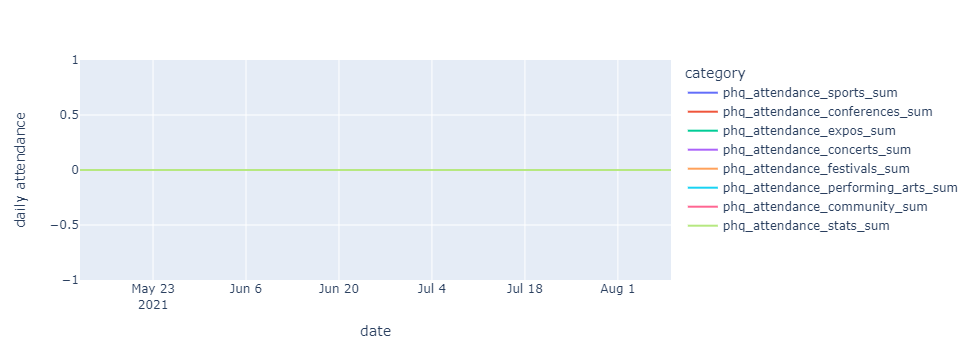

In [165]:
to_plot = df.filter(regex="sum")
fig = px.line(
    to_plot,
    labels={"value": "daily attendance", "variable": "category"},
)

for date in outlier_dates:

    fig.add_vrect(
        x0=date - datetime.timedelta(days=1),
        x1=date + datetime.timedelta(days=1),
        fillcolor="LightSalmon",
        opacity=0.5,
        layer="below",
        line_width=0,
    )

fig.show()

## Summary stats

Please note, a cluster is a collection of consecutive outlier days

In [166]:
stats = df[df.index.isin(outlier_dates)].copy()
stats["cluster"] = (stats.index.to_series().diff() != pd.Timedelta("1d")).cumsum()
summary_stats = stats.assign(
        phq_attendance_stats_sum_cluster=stats.groupby(
            ["cluster"]
        ).phq_attendance_stats_sum.transform("sum")
    ).filter(regex="phq_attendance_stats_").rename(
        columns={
            "phq_attendance_stats_sum": "total daily attendance",
            "phq_attendance_stats_count": "total daily event count",
            "phq_attendance_stats_sum_cluster": "total cluster attendance",
        }
    )
summary_stats["surge category"] = list(outlier_dates_category['surge_category'])
#reorder the columns
summary_stats = summary_stats[['surge category', 'total daily attendance', 'total daily event count', 'total cluster attendance']]
summary_stats

,surge category,total daily attendance,total daily event count,total cluster attendance
date,,,,


# Events API <a class="anchor" id="events-api"></a>

In [65]:
def set_up_parameters(
    start_time,
    end_time,
    location_setting,
    latitude,
    longitude,
    radius,
    radius_unit,
    place_id,
):
    """Set up parameters to query the Events API"""

    parameters = dict()

    if location_setting == "place_id":
        parameters.update(place__scope=place_id)

    elif location_setting == "lat/lon":
        within = f"{radius}{radius_unit}@{latitude},{longitude}"
        parameters.update(within=within)

    parameters.update(active__gte=start_time)
    parameters.update(active__lte=end_time)

    timezone = TimezoneFinder().timezone_at(lat=latitude, lng=longitude)
    parameters.update(active__tz=timezone)

    rank_type = "rank"
    rank_threshold = 0
    filter_parameter = "gt"
    parameters.update({f"{rank_type}__{filter_parameter}": rank_threshold})

    categories = [
        "conferences",
        "expos",
        "concerts",
        "festivals",
        "performing-arts",
        "sports",
        "community",
    ]
    parameters.update(category=categories)

    parameters.update(limit=500)

    return parameters

In [66]:
def load_events(parameters, client):
    """Query Events API"""

    results = []

    for event in client.events.search(parameters).iter_all():
        results.append(event.to_dict())

    df = pd.DataFrame(results)
    df["category"] = df["category"].str.replace("-", "_")  # clean values

    return df

In [67]:
def get_local_dt(dt, tz):
    """Localize a datetime for a given timezone"""

    if not dt:
        return None

    dt = rfc3339.parse_datetime(dt)

    if not tz:
        return dt

    local_dt = dt.astimezone(pytz.timezone(tz))

    return local_dt

In [68]:
def process_start_and_end_dt(df, start="start", end="end", tz="timezone"):
    """Derive local start and end date/time"""

    tmp = df.copy()

    tmp["start_local"] = tmp.apply(
        lambda row: get_local_dt(str(row[start]), row[tz]), axis=1
    )
    tmp["start_local_date"] = tmp.start_local.map(lambda x: x.date())
    tmp["end_local"] = tmp.apply(
        lambda row: get_local_dt(str(row[end]), row[tz]), axis=1
    )
    tmp["end_local_date"] = tmp.end_local.map(lambda x: x.date())

    return tmp

In [69]:
def extract_event_ids_from_dates(df, dates_list):
    """Extract unique event ids which overlap with specified dates"""

    tmp = df.copy()
    events_df = pd.DataFrame()

    for date in dates_list:

        tmp1 = tmp.loc[
            (tmp["start_local_date"] <= date) & (tmp["end_local_date"] >= date)
        ][["id"]]
        tmp1["date"] = date

        events_df = events_df.append(tmp1)

    return events_df

In [70]:
attended_events_cols = [
    "date",
    "id",
    "category",
    "labels",
    "title",
    "description",
    "start_local",
    "end_local",
    "duration",
    "country",
    "rank",
    "phq_attendance",
]

## Top events

Assumptions:
* At least one outlier day is detected

In [71]:
start = min(outlier_dates).strftime("%Y-%m-%d")
end = max(outlier_dates).strftime("%Y-%m-%d")

parameters = set_up_parameters(
    start_time=start,
    end_time=end,
    location_setting=LOCATION_SETTING,
    latitude=latitude,
    longitude=longitude,
    radius=radius,
    radius_unit=radius_unit,
    place_id=place_id,
)

events_df = load_events(parameters=parameters, client=phq)
events_df = process_start_and_end_dt(df=events_df)

In [72]:
event_ids = extract_event_ids_from_dates(df=events_df, dates_list=outlier_dates)
top_events = pd.merge(events_df, event_ids, how="inner", on="id")

## Top 10 events

In [73]:
for date in outlier_dates:

    display(
        top_events.filter(attended_events_cols)
        .loc[top_events["date"] == date]
        .sort_values(by=["phq_attendance"], ascending=[False])
        .head(10)
        .reset_index(drop=True)
    )

,date,id,category,labels,title,description,start_local,end_local,duration,country,rank,phq_attendance
0,2021-08-07,UfbhzKgAcmRnybUKTS,festivals,"[festival, music]",BBC Proms,"The Proms or BBC Proms, formally named the Hen...",2021-07-30 00:00:00+01:00,2021-09-11 23:59:59+01:00,3801599,GB,98,240000
1,2021-08-07,UHvrnMx7ukpwBtuXFx,sports,"[soccer, sport]",Community Shield - Final - Leicester City vs M...,,2021-08-07 17:15:00+01:00,2021-08-07 17:15:00+01:00,0,GB,83,45602
2,2021-08-07,uxaD3CE3EfWnJoNUnZ,concerts,"[concert, music]",Sonny Fodera & Gorgon City present: Back to Love,,2021-08-07 13:00:00+01:00,2021-08-07 13:00:00+01:00,0,GB,82,39200
3,2021-08-07,VrNcjFdkt3ox87Hvrg,sports,"[soccer, sport]",Club Friendlies - Club Friendlies 3 - West Ham...,,2021-08-07 15:00:00+01:00,2021-08-07 15:00:00+01:00,0,GB,81,36630
4,2021-08-07,FjPotx4RqvhR6NSRUx,sports,"[sport, triathlon]",London Triathlon,"The London Triathlon also known as the ""AJ Bel...",2021-08-07 00:00:00+01:00,2021-08-08 23:59:59+01:00,172799,GB,78,24000
5,2021-08-07,7FkbzDtYVzZqBoEtpg,sports,"[soccer, sport]",League One - Charlton Athletic vs Sheffield We...,,2021-08-07 17:30:00+01:00,2021-08-07 17:30:00+01:00,0,GB,75,17639
6,2021-08-07,xWyUHWRSbBCoxXWyEn,sports,"[soccer, sport]",Championship - Queens Park Rangers vs Millwall,,2021-08-07 15:00:00+01:00,2021-08-07 15:00:00+01:00,0,GB,74,16127
7,2021-08-07,ah3KD2gq4rTxu4dLrD,sports,"[soccer, sport]",Club Friendlies - Club Friendlies 3 - Crystal ...,,2021-08-07 15:00:00+01:00,2021-08-07 15:00:00+01:00,0,GB,69,8676
8,2021-08-07,8tcSK2NrsWBbumivFY,sports,"[soccer, sport]",Club Friendlies - Club Friendlies 3 - Brentfor...,,2021-08-07 17:30:00+01:00,2021-08-07 17:30:00+01:00,0,GB,66,6088
9,2021-08-07,bxwkehyZMW8WHhoSuH,festivals,"[festival, sport]",LDN 7's Festival,LDN 7's Festival is a London sports and music ...,2021-08-07 00:00:00+01:00,2021-08-08 23:59:59+01:00,172799,GB,64,5000


,date,id,category,labels,title,description,start_local,end_local,duration,country,rank,phq_attendance
0,2021-08-08,UfbhzKgAcmRnybUKTS,festivals,"[festival, music]",BBC Proms,"The Proms or BBC Proms, formally named the Hen...",2021-07-30 00:00:00+01:00,2021-09-11 23:59:59+01:00,3801599,GB,98,240000
1,2021-08-08,Lc5Rao4WdVZLCbnomg,festivals,"[community, festival]",Our Community Festival,"Our Community Festival - Fun, Family friendly ...",2021-08-08 12:00:00+01:00,2021-08-08 17:00:00+01:00,18000,GB,86,64000
2,2021-08-08,GVrzjmd9Xoj776HESJ,sports,"[soccer, sport]",Club Friendlies Women - Club Friendlies 1 - To...,,2021-08-08 16:45:00+01:00,2021-08-08 16:45:00+01:00,0,GB,82,41407
3,2021-08-08,kzpieT8RQDjxzcmi5Q,concerts,"[concert, music]",Extra Date: Sonny Fodera & Gorgon City present...,,2021-08-08 13:00:00+01:00,2021-08-08 13:00:00+01:00,0,GB,82,39200
4,2021-08-08,QbY2ZXAEgMezUkBTzx,sports,"[soccer, sport]",Club Friendlies - Club Friendlies 1 - Tottenha...,,2021-08-08 14:00:00+01:00,2021-08-08 14:00:00+01:00,0,GB,78,25000
5,2021-08-08,FjPotx4RqvhR6NSRUx,sports,"[sport, triathlon]",London Triathlon,"The London Triathlon also known as the ""AJ Bel...",2021-08-07 00:00:00+01:00,2021-08-08 23:59:59+01:00,172799,GB,78,24000
6,2021-08-08,4hw5tTgN8MW7jH4o4w,sports,"[cricket, sport]",Oval Invincibles vs Trent Rockets,,2021-08-08 15:30:00+01:00,2021-08-08 15:30:00+01:00,0,GB,76,20800
7,2021-08-08,T9yvBXT9FWKtGbNxNs,sports,"[soccer, sport]",Championship - Fulham vs Middlesbrough,,2021-08-08 13:30:00+01:00,2021-08-08 13:30:00+01:00,0,GB,74,16058
8,2021-08-08,pC35xRf5zboLa2mRfq,sports,"[cricket, sport]",Kent vs Hampshire,,2021-08-08 11:00:00+01:00,2021-08-08 18:07:18+01:00,25638,GB,68,8000
9,2021-08-08,3VevqgDRDbccbrC2LH,sports,"[cricket, sport]",Derbyshire vs Yorkshire,,2021-08-08 11:00:00+01:00,2021-08-08 18:33:52+01:00,27232,GB,65,5600
